In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [4]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models


10:15:40 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
10:15:40 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

Initialize surface system

In [5]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

10:15:40 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}


10:15:40 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
10:15:40 - mcmc.system | INFO: Initializing 64 virtual atoms
10:15:40 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10:15:40 - mcmc.system | INFO: Number of pristine atoms is 60
10:15:40 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
10:15:40 - mcmc.system | INFO: Surface indices are [ 7  8 22 23 37 38 52 53]
10:15:40 - mcmc.system | INFO: Constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

      Step     Time          Energy         fmax
BFGS:    0 10:15:41     -467.521881        0.2044
BFGS:    1 10:15:41     -467.525757        0.1803
BFGS:    2 10:15:41     -467.540619        0.0793
BFGS:    3 10:15:41     -467.540924        0.0598
BFGS:    4 10:15:41     -467.541351        0.0059


Calculate pristine surface energy

In [6]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

10:15:41 - mcmc.mcmc | INFO: Using run folder SrTiO3(001)
10:15:41 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
10:15:41 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
10:15:41 - mcmc.mcmc | INFO: Starting with iteration 0
10:15:41 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
10:15:41 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:41     -470.092041        1.9476
BFGS:    1 10:15:42     -470.202545        1.3805
BFGS:    2 10:15:42     -470.321777        0.5470
BFGS:    3 10:15:42     -470.333130        0.4195
BFGS:    4 10:15:42     -470.355377        0.2154
BFGS:    5 10:15:42     -470.357788        0.2067
BFGS:    6 10:15:42     -470.364227        0.1401
BFGS:    7 10:15:42     -470.365326        0.1282
BFGS:    8 10:15:42     -470.367096        0.0619
BFGS:    9 10:15:42     -470.367310        0.0711
BFGS:   10 10:15:42     -470.367828        0.0536
BFGS:   11 10:15:42     -470.368011        0.0491
BFGS:   12 10:15:43     -470.368378        0.0364
BFGS:   13 10:15:43     -470.368500        0.0283
BFGS:   14 10:15:43     -470.368652        0.0338
BFGS:   15 10:15:43     -470.368866        0.0374
BFGS:   16 10:15:43     -470.369049        0.0417
BFGS:   17 10:15:43     -470.369293        0.0385
BFGS:   18 10:15:43     -470.369507        0.0337
B

10:15:52 - mcmc.system | INFO: Optimized structure has Energy = 12.067
10:15:52 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:15:52     -464.742676       24.6833
BFGS:    1 10:15:52     -468.447113       12.6240
BFGS:    2 10:15:52     -470.479980        6.2090
BFGS:    3 10:15:52     -471.836273        3.1233
BFGS:    4 10:15:52     -472.702515        2.8286
BFGS:    5 10:15:52     -472.992279        2.9598
BFGS:    6 10:15:52     -473.171631        2.1248
BFGS:    7 10:15:52     -473.606323        1.4130
BFGS:    8 10:15:52     -473.944244        1.9682
BFGS:    9 10:15:53     -474.087250        1.3207
BFGS:   10 10:15:53     -474.412262        1.1066
BFGS:   11 10:15:53     -474.660248        1.5008
BFGS:   12 10:15:53     -474.736053        2.0933
BFGS:   13 10:15:53     -474.896576        1.5876
BFGS:   14 10:15:53     -475.161896        0.8093
BFGS:   15 10:15:53     -475.224457        0.8682
BFGS:   16 10:15:53     -475.313141        1.0404
BFGS:   17 10:15:53     -475.394135        0.7718
BFGS:   18 10:15:53     -475.510254        0.7328
B

10:16:01 - mcmc.system | INFO: Optimized structure has Energy = 11.999
10:16:01 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:02     -474.248779       27.5050
BFGS:    1 10:16:02     -481.160309       16.3761
BFGS:    2 10:16:02     -485.033966        8.3543
BFGS:    3 10:16:02     -488.189331        5.6898
BFGS:    4 10:16:02     -490.508789        4.4552
BFGS:    5 10:16:02     -491.635101        3.9265
BFGS:    6 10:16:02     -492.245483        3.3324
BFGS:    7 10:16:02     -493.275757        2.9408
BFGS:    8 10:16:02     -493.993408        3.7621
BFGS:    9 10:16:02     -494.672821        3.6058
BFGS:   10 10:16:03     -495.493774        3.0924
BFGS:   11 10:16:03     -496.372345        3.1382
BFGS:   12 10:16:03     -497.227936        4.0673
BFGS:   13 10:16:03     -498.258209        4.2884
BFGS:   14 10:16:03     -499.193115        4.0828
BFGS:   15 10:16:03     -499.976532        3.3396
BFGS:   16 10:16:03     -500.725189        2.1729
BFGS:   17 10:16:03     -501.246704        1.7601
BFGS:   18 10:16:03     -501.702881        1.6101
B

10:16:12 - mcmc.system | INFO: Optimized structure has Energy = 6.528
10:16:12 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:12     -471.005585       27.1581
BFGS:    1 10:16:12     -481.539642       16.8374
BFGS:    2 10:16:12     -486.873444        8.8391
BFGS:    3 10:16:12     -490.724243        5.0610
BFGS:    4 10:16:12     -492.934814        2.9619
BFGS:    5 10:16:12     -494.185059        2.3398
BFGS:    6 10:16:13     -494.890106        2.5055
BFGS:    7 10:16:13     -495.511261        3.6457
BFGS:    8 10:16:13     -496.471680        4.2185
BFGS:    9 10:16:13     -497.511810        3.8035
BFGS:   10 10:16:13     -498.494720        3.1036
BFGS:   11 10:16:13     -499.515381        2.5970
BFGS:   12 10:16:13     -500.175995        2.6965
BFGS:   13 10:16:13     -500.803070        2.5032
BFGS:   14 10:16:13     -501.877106        2.2206
BFGS:   15 10:16:13     -502.219086        1.5294
BFGS:   16 10:16:14     -502.738037        1.3324
BFGS:   17 10:16:14     -503.011627        1.3856
BFGS:   18 10:16:14     -503.240021        1.7497
B

10:16:22 - mcmc.system | INFO: Optimized structure has Energy = 7.317
10:16:22 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:22     -480.006073       28.1715
BFGS:    1 10:16:22     -491.997650       17.5059
BFGS:    2 10:16:22     -498.355255        9.8258
BFGS:    3 10:16:22     -503.605927        6.0637
BFGS:    4 10:16:22     -507.368805        4.4216
BFGS:    5 10:16:22     -510.028107        3.5159
BFGS:    6 10:16:22     -511.797119        2.6342
BFGS:    7 10:16:23     -513.075195        3.3904
BFGS:    8 10:16:23     -514.086487        4.2252
BFGS:    9 10:16:23     -515.055481        4.4515
BFGS:   10 10:16:23     -516.567078        3.3102
BFGS:   11 10:16:23     -517.679443        3.4849
BFGS:   12 10:16:23     -518.593140        3.7363
BFGS:   13 10:16:23     -519.262146        2.6544
BFGS:   14 10:16:23     -519.655273        2.5394
BFGS:   15 10:16:23     -519.890564        1.7615
BFGS:   16 10:16:23     -520.352905        1.3431
BFGS:   17 10:16:23     -520.635315        1.4162
BFGS:   18 10:16:24     -520.841248        1.5244
B

10:16:32 - mcmc.system | INFO: Optimized structure has Energy = 6.927
10:16:32 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:32    34315.113281   815140.3007
BFGS:    1 10:16:32     -428.036713      377.7499
BFGS:    2 10:16:32     -447.411133      372.2320
BFGS:    3 10:16:32     -472.811768       59.7492
BFGS:    4 10:16:32     -475.233551       41.5240
BFGS:    5 10:16:32     -484.839203       57.3379
BFGS:    6 10:16:32     -488.545990       64.9769
BFGS:    7 10:16:32     -492.058105       21.8510
BFGS:    8 10:16:32     -494.403351        3.7586
BFGS:    9 10:16:32     -495.851166       11.6957
BFGS:   10 10:16:33     -496.901764        6.2146
BFGS:   11 10:16:33     -498.188354        3.8845
BFGS:   12 10:16:33     -499.428345        5.8373
BFGS:   13 10:16:33     -500.601074        5.6582
BFGS:   14 10:16:33     -501.128784        6.4194
BFGS:   15 10:16:33     -501.381317        9.6184
BFGS:   16 10:16:33     -501.811859        8.6205
BFGS:   17 10:16:33     -502.045166        4.2890
BFGS:   18 10:16:33     -502.307495        3.0634
B

10:16:41 - mcmc.system | INFO: Optimized structure has Energy = 6.927
10:16:41 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:41     -455.832916       32.2707
BFGS:    1 10:16:41     -472.473114       18.3258
BFGS:    2 10:16:41     -480.636322       10.5284
BFGS:    3 10:16:41     -486.994751        6.3227
BFGS:    4 10:16:42     -491.180756        4.2794
BFGS:    5 10:16:42     -494.125366        3.2190
BFGS:    6 10:16:42     -496.000946        2.6514
BFGS:    7 10:16:42     -497.370331        3.4939
BFGS:    8 10:16:42     -498.384918        3.1817
BFGS:    9 10:16:42     -499.035126        3.0336
BFGS:   10 10:16:42     -500.222290        2.0890
BFGS:   11 10:16:42     -500.475586        1.6753
BFGS:   12 10:16:42     -500.730377        1.4224
BFGS:   13 10:16:42     -501.008636        1.4005
BFGS:   14 10:16:42     -501.240936        1.2286
BFGS:   15 10:16:43     -501.439056        1.3347
BFGS:   16 10:16:43     -501.689697        2.0347
BFGS:   17 10:16:43     -501.882843        2.0724
BFGS:   18 10:16:43     -502.130951        1.5553
B

10:16:53 - mcmc.system | INFO: Optimized structure has Energy = 5.972
10:16:53 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:16:53     -444.644653       54.1981
BFGS:    1 10:16:53     -471.411652       20.4333
BFGS:    2 10:16:53     -488.523407       13.3237
BFGS:    3 10:16:54     -500.383087       10.0817
BFGS:    4 10:16:54     -507.745758        7.5664
BFGS:    5 10:16:54     -513.197815        6.5636
BFGS:    6 10:16:54     -517.673584        5.7141
BFGS:    7 10:16:54     -520.575439        4.4117
BFGS:    8 10:16:54     -522.350586        4.0085
BFGS:    9 10:16:54     -524.008362        3.6715
BFGS:   10 10:16:54     -525.571228        3.4260
BFGS:   11 10:16:54     -527.066956        3.8997
BFGS:   12 10:16:54     -528.217896        3.8406
BFGS:   13 10:16:55     -528.836792        2.4286
BFGS:   14 10:16:55     -529.461853        1.7160
BFGS:   15 10:16:55     -529.814514        1.5167
BFGS:   16 10:16:55     -530.171204        1.4693
BFGS:   17 10:16:55     -530.511169        1.4172
BFGS:   18 10:16:55     -530.770752        1.6766
B

10:17:04 - mcmc.system | INFO: Optimized structure has Energy = 4.486
10:17:04 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:17:04     -357.140991      448.6734
BFGS:    1 10:17:04     -359.418060      320.8253
BFGS:    2 10:17:04     -401.491302       51.8653
BFGS:    3 10:17:04     -432.727631       53.5235
BFGS:    4 10:17:04     -454.304199       38.8531
BFGS:    5 10:17:04     -470.745361       25.6621
BFGS:    6 10:17:05     -483.367676       19.0000
BFGS:    7 10:17:05     -492.991608       12.4994
BFGS:    8 10:17:05     -500.957733        7.8616
BFGS:    9 10:17:05     -507.396027        5.0124
BFGS:   10 10:17:05     -511.966888        3.6579
BFGS:   11 10:17:05     -514.950867        4.1264
BFGS:   12 10:17:05     -517.285034        3.9307
BFGS:   13 10:17:05     -518.929504        3.6941
BFGS:   14 10:17:05     -520.313660        3.8527
BFGS:   15 10:17:05     -521.491882        3.1477
BFGS:   16 10:17:05     -522.478516        2.6767
BFGS:   17 10:17:06     -523.530090        2.6005
BFGS:   18 10:17:06     -523.993469        2.4358
B

10:17:15 - mcmc.system | INFO: Optimized structure has Energy = 2.928
10:17:15 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:17:15     -402.899536       86.4666
BFGS:    1 10:17:15     -444.857819       29.3802
BFGS:    2 10:17:15     -467.491943       22.6301
BFGS:    3 10:17:15     -484.124603       18.1843
BFGS:    4 10:17:15     -497.826569       10.4960
BFGS:    5 10:17:15     -507.634644        8.1286
BFGS:    6 10:17:15     -514.592957        6.3138
BFGS:    7 10:17:15     -519.940613        5.1067
BFGS:    8 10:17:16     -524.279785        5.0804
BFGS:    9 10:17:16     -527.565247        5.2343
BFGS:   10 10:17:16     -529.633545        4.3893
BFGS:   11 10:17:16     -531.704529        5.6408
BFGS:   12 10:17:16     -533.617676        4.0574
BFGS:   13 10:17:16     -535.490295        5.0056
BFGS:   14 10:17:16     -536.945251        3.6051
BFGS:   15 10:17:16     -538.089050        4.1417
BFGS:   16 10:17:16     -539.145203        4.1110
BFGS:   17 10:17:16     -540.141052        3.0819
BFGS:   18 10:17:16     -541.059265        2.9405
B

10:17:25 - mcmc.system | INFO: Optimized structure has Energy = 1.265


Time taken = 104.208 seconds


Plot results

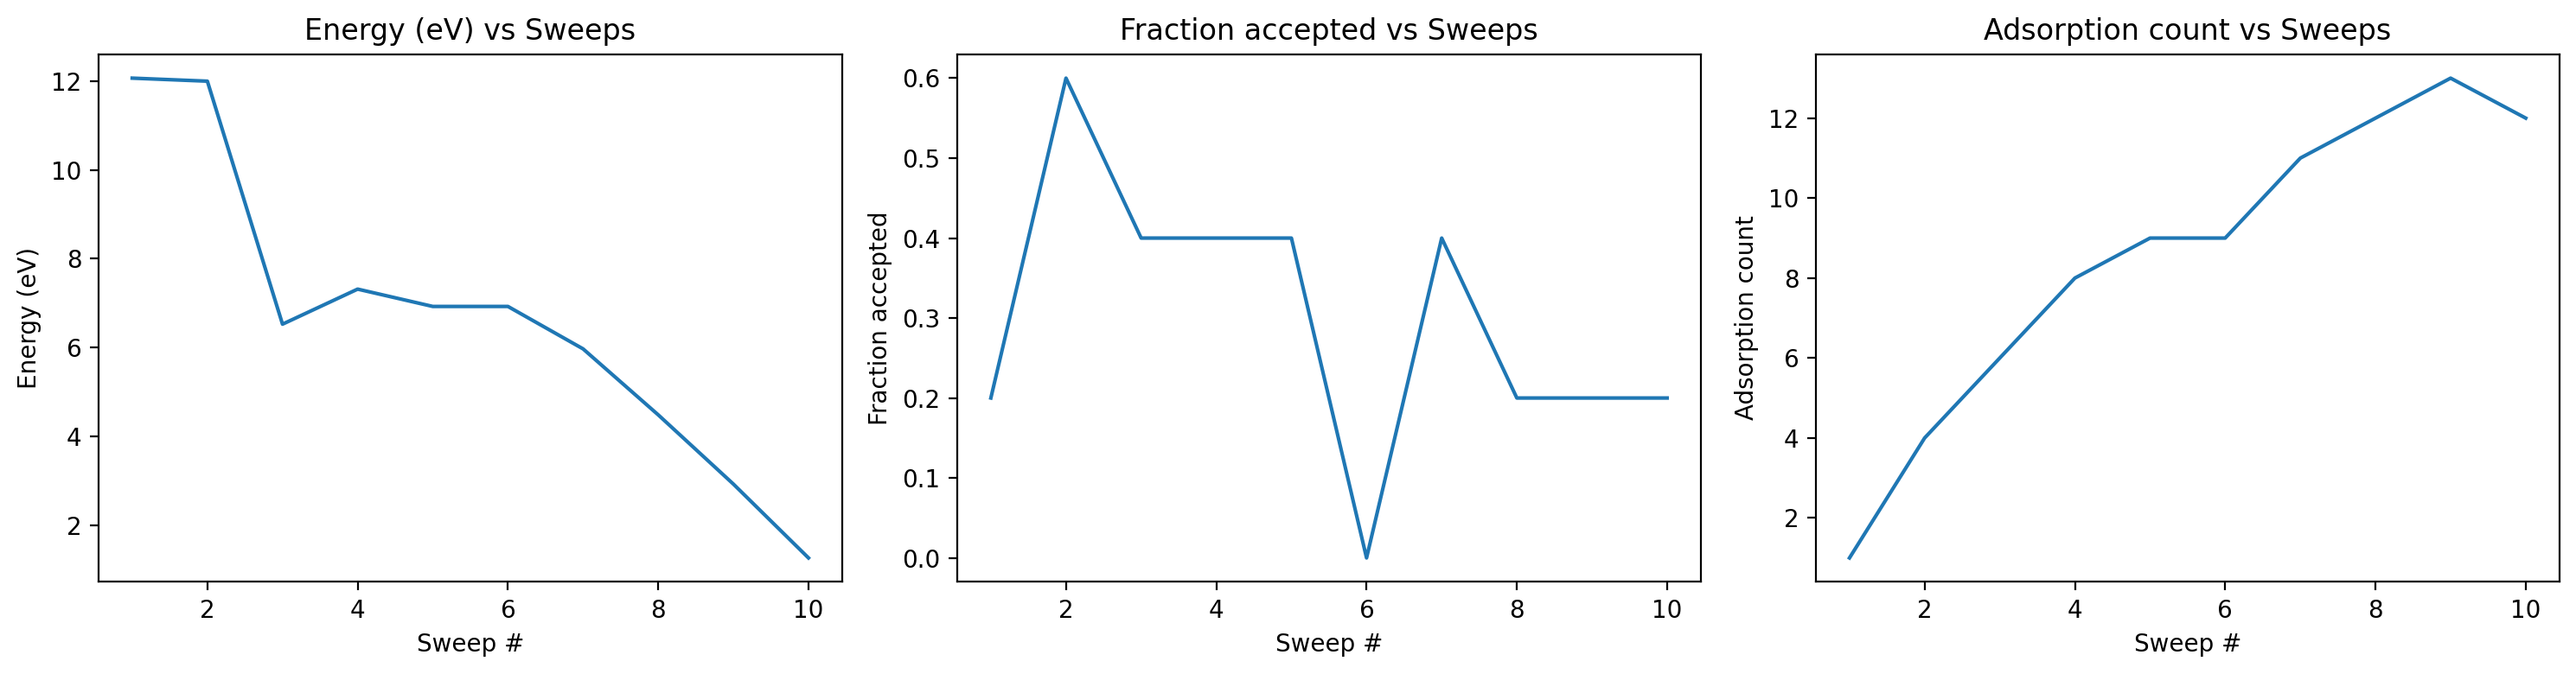

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [9]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)